# Convolutional Autoencoder for Representation Learning and CNN Pretraining

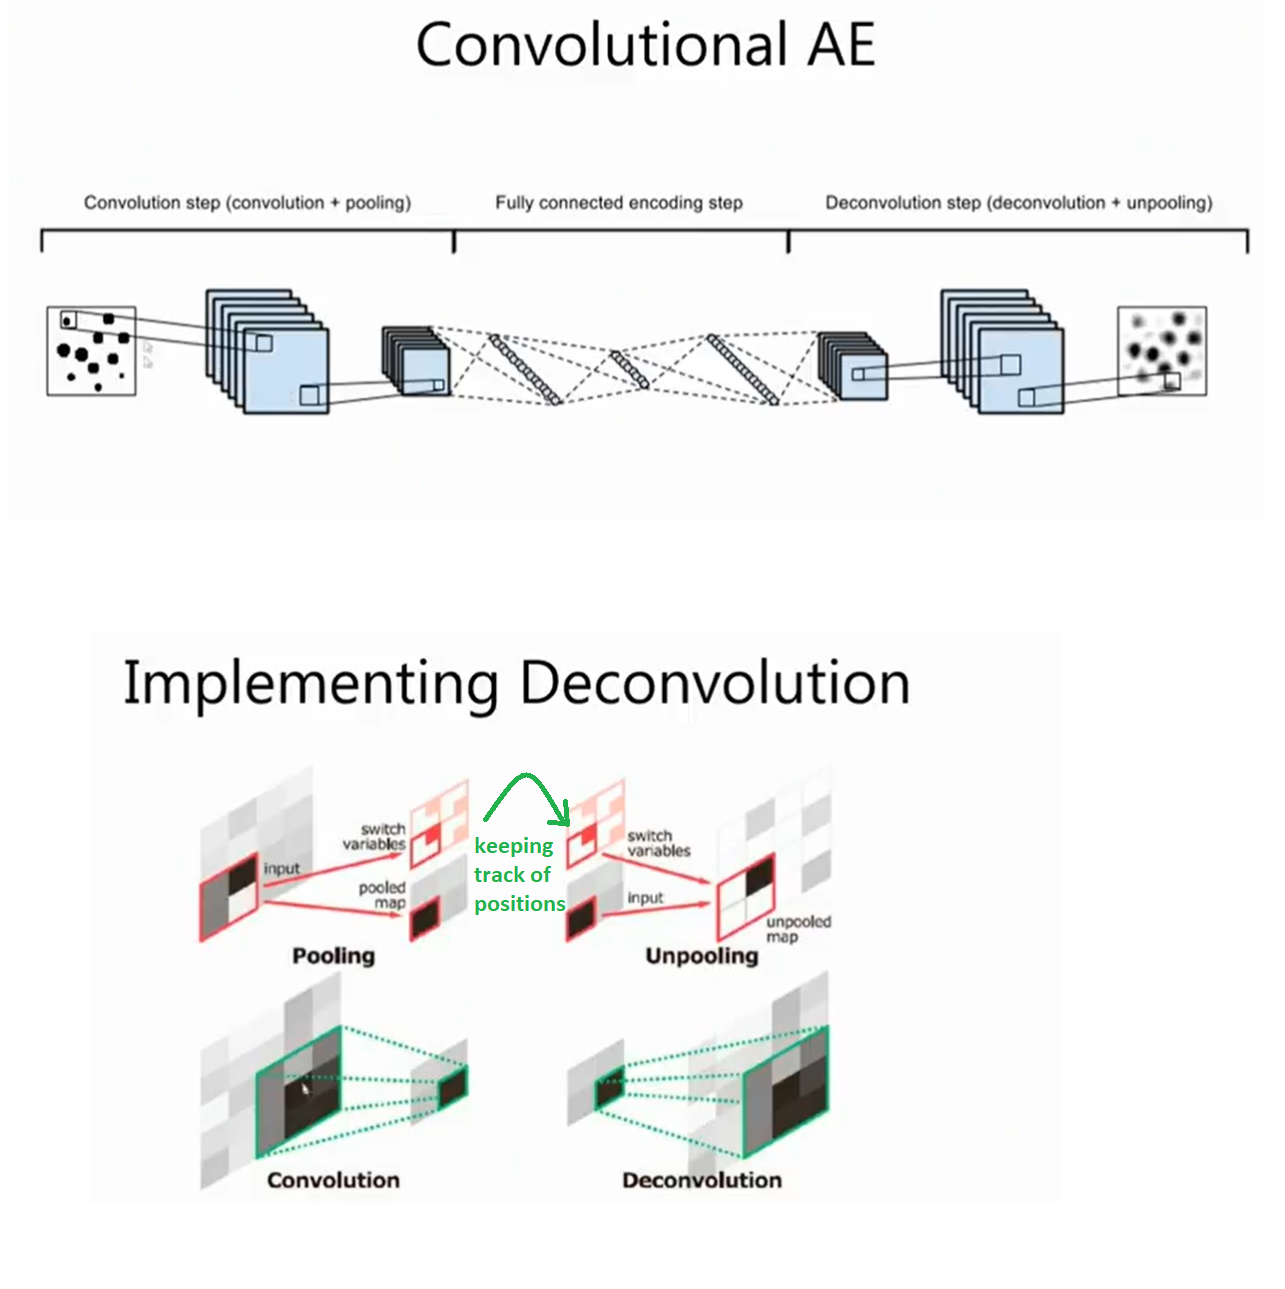

## Imports

In [1]:
%matplotlib inline
import copy
import time
import tqdm
import torch
import numpy as np
import torchvision
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.5.0


## Load Data:

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 200 

trainset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


## Convolutional Autoencoder:


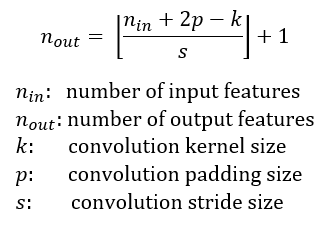

<b> Convolutional Encoder  </b> <br>
3 channel image -> <br> CONV(64 channels (3x3 kernel , stride=2, padding=1)) -><br> CONV(128 channels(3x3 kernel , stride=2, padding=1)) -> <br> CONV(128 channels (3x3 kernel , stride=2, padding=1))->
<br><br>
<b> Fully Connected Encoder  </b> <br>
LINEAR(128x 4 x 4 -> 1024) -> <br><br>
<b> Fully Connected Decoder  </b> <br>
LINEAR(1024 -> 128x 4 x 4 ) -> <br><br>

<b> Convolutional Decoder  </b> <br>
CONV(128 channels (3x3 kernel , stride=1, padding=1)) -> <br> 
UPSAMPLING(2 , 'bilinear') ->  ### Converts 4x4 image   into 8x8 image <br>
CONV(128 channels(3x3 kernel , stride=1, padding=1)) -> <br>
CONV(64 channels (3x3 kernel , stride=1, padding=1))->

In [10]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.conv_encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1))
        
        self.fc_encoder = nn.Sequential(
            nn.Linear(128*4*4,1024),
            nn.LeakyReLU(0.1))
        
        self.fc_decoder = nn.Sequential(
            nn.Linear(1024,128*4*4),
            nn.LeakyReLU(0.1))
        
        self.conv_decoder = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU())

    def forward(self, x):
        x = self.conv_encoder(x)
        x = x.view(-1, 128*4*4)  #in-order to pass it through Fully copnnected Layer
        x = self.fc_encoder(x)
        x = self.fc_decoder(x)
        x = x.view(-1, 128,4,4) #in-order to pass it through CONVOLUTIONAL DECODER
        x = self.conv_decoder(x)
        return x

In [12]:
net = autoencoder()
net = net.to(device)
init_weights = copy.deepcopy(net.conv_encoder[0].weight.data)
print(net)

autoencoder(
  (conv_encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1)
  )
  (fc_encoder): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (fc_decoder): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv_decoder): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Upsample(scale_factor=2.0, mode=bilinear)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): Upsample(scale_fac

## Train Autoencoder:


In [13]:
iterations = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [14]:
BatchSize

200

C:\Users\Ashwin\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


C:\Users\Ashwin\Miniconda3\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



Iteration: 1 /10  ;  Training Loss: 0.035792 ; Time consumed: 1m 23s 



Iteration: 2 /10  ;  Training Loss: 0.014595 ; Time consumed: 1m 12s 



Iteration: 3 /10  ;  Training Loss: 0.012330 ; Time consumed: 1m 12s 



Iteration: 4 /10  ;  Training Loss: 0.010487 ; Time consumed: 1m 12s 



Iteration: 5 /10  ;  Training Loss: 0.009543 ; Time consumed: 1m 14s 



Iteration: 6 /10  ;  Training Loss: 0.008840 ; Time consumed: 1m 13s 



Iteration: 7 /10  ;  Training Loss: 0.008372 ; Time consumed: 1m 13s 



Iteration: 8 /10  ;  Training Loss: 0.007941 ; Time consumed: 1m 13s 



Iteration: 9 /10  ;  Training Loss: 0.007786 ; Time consumed: 1m 25s 



Iteration: 10 /10  ;  Training Loss: 0.007128 ; Time consumed: 1m 21s 
Finished Training


Text(0, 0.5, 'Training loss')

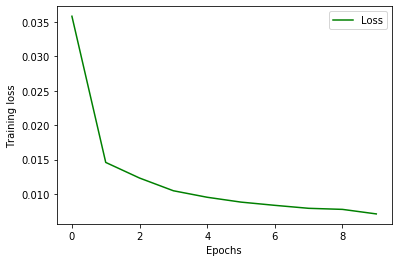

In [6]:
trainLoss = []
for epoch in range(iterations):  # loop over the dataset multiple times
    epochStart = time.time()
    runningLoss = 0.0
    for data in tqdm.tqdm_notebook(trainloader):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        
        optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, inputs) # calculate loss
        loss.backward() #  backpropagate the loss        
        optimizer.step()
        
        runningLoss += loss.item()
    trainLoss.append((runningLoss/(60000/BatchSize)))
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,runningLoss/(60000/BatchSize),epochEnd//60,epochEnd%60))   
print('Finished Training')

fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss') 

## Weights Visualization:


In [15]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

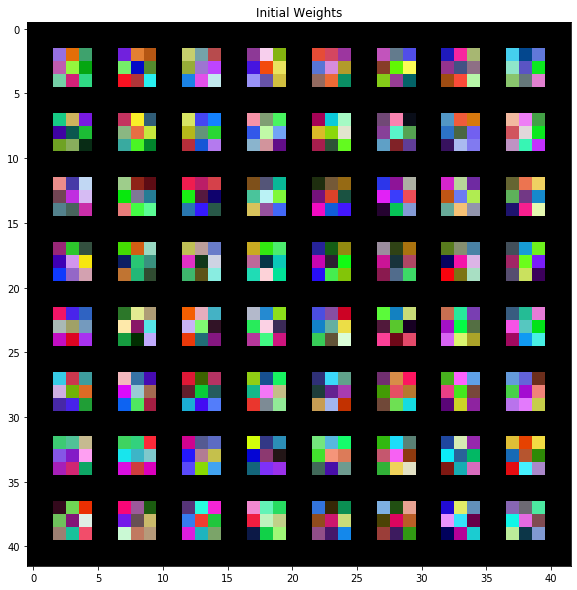

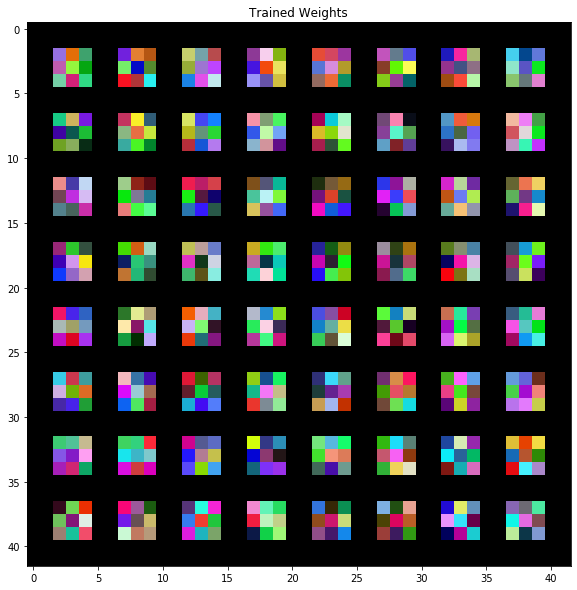

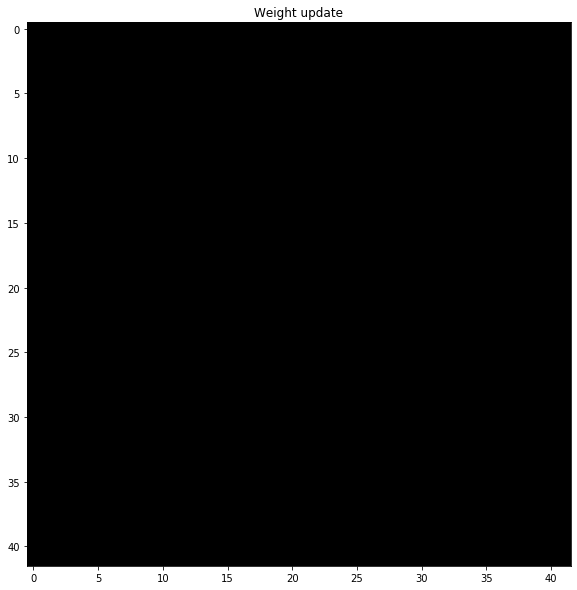

In [20]:
trained_weights = copy.deepcopy(net.conv_encoder[0].weight.data)
init_weights = init_weights.view(64,3,3,3)
trained_weights = trained_weights.view(64,3,3,3)

if use_gpu:
    init_weights = init_weights.cpu()
    trained_weights = trained_weights.cpu()
    
d_weights = init_weights - trained_weights 
d_weights = d_weights.view(64,3,3,3)

imshow(torchvision.utils.make_grid(init_weights,nrow=8,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weights,nrow=8,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=8,normalize=True), 'Weight update')

## Modifying the autoencoder for classification:

- Initializing the Classifier using the trained autoencoder(<b>encoder </b>) to better pickup rich features

In [21]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = net.conv_encoder  #net. is previously trained network
        self.fc1 = net.fc_encoder
        self.fc2 = nn.Sequential(nn.Linear(1024, 10))

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128*4*4)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [22]:
net = Model()
print(net)
# Copying initial weights  for visualization
cll_weights = copy.deepcopy(net.conv[0].weight.data)
net = net.to(device)

Model(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1024, out_features=10, bias=True)
  )
)


## Train Classifier:


C:\Users\Ashwin\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



Iteration: 1 /5  ;  Training Loss: 1.327307 ; Testing Acc: 52.040 ; Time consumed: 0m 44s 



Iteration: 2 /5  ;  Training Loss: 0.994414 ; Testing Acc: 60.350 ; Time consumed: 0m 44s 



Iteration: 3 /5  ;  Training Loss: 0.827890 ; Testing Acc: 64.820 ; Time consumed: 0m 45s 



Iteration: 4 /5  ;  Training Loss: 0.687125 ; Testing Acc: 66.970 ; Time consumed: 0m 43s 



Iteration: 5 /5  ;  Training Loss: 0.566587 ; Testing Acc: 68.020 ; Time consumed: 0m 43s 
Finished Training


Text(0, 0.5, 'Test Accuracy')

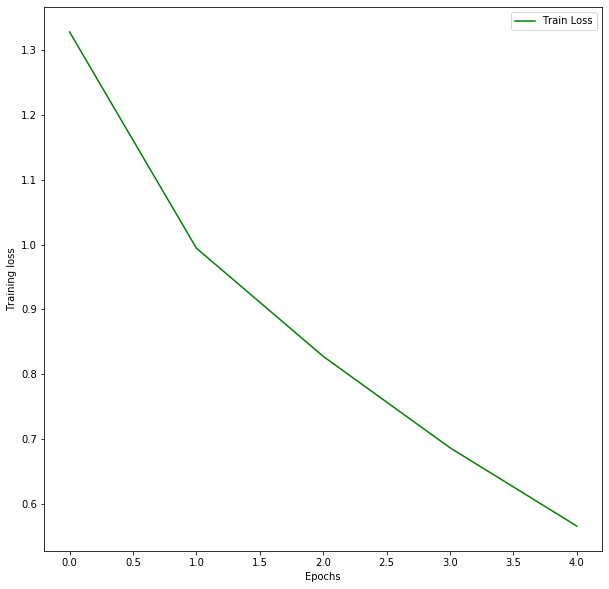

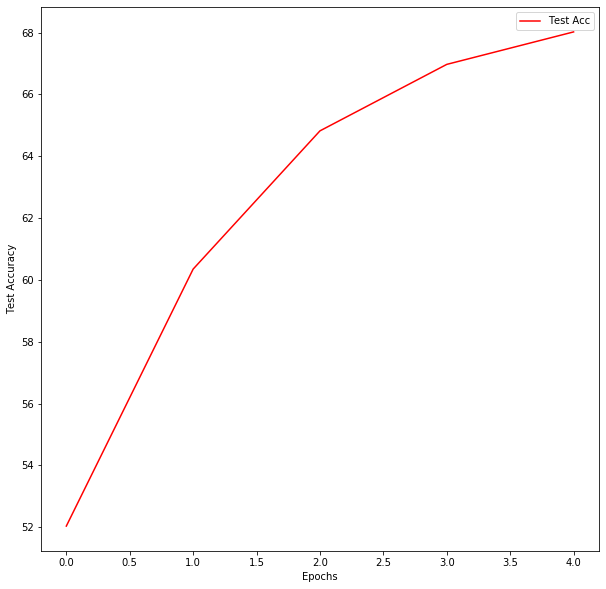

In [23]:
iterations = 5
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
trainLoss = []
testacc = []

for epoch in range(iterations):  # loop over the dataset multiple times
    epochStart = time.time()
    runningLoss = 0.0
    net.train()
    for data in tqdm.tqdm_notebook(trainloader):
        # get the inputs
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        
        runningLoss += loss.item()
        correct = 0
        total = 0
    
    net.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    trainLoss.append((runningLoss/(60000/BatchSize)))
    testacc.append(100 * float(correct) /float(total))
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,runningLoss/(60000/BatchSize),100 * float(correct) /float(total),epochEnd//60,epochEnd%60))

print('Finished Training')

fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Train Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss') 

fig = plt.figure()        
plt.plot(range(epoch+1),testacc,'r-',label='Test Acc')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy') 

## Encoder Weights Visualization:

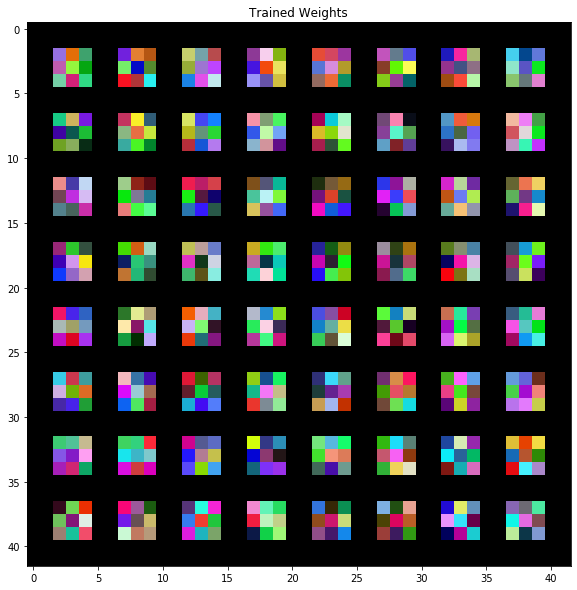

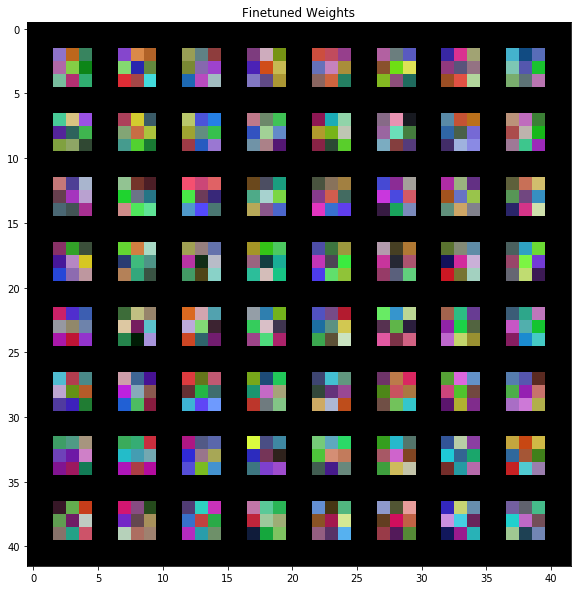

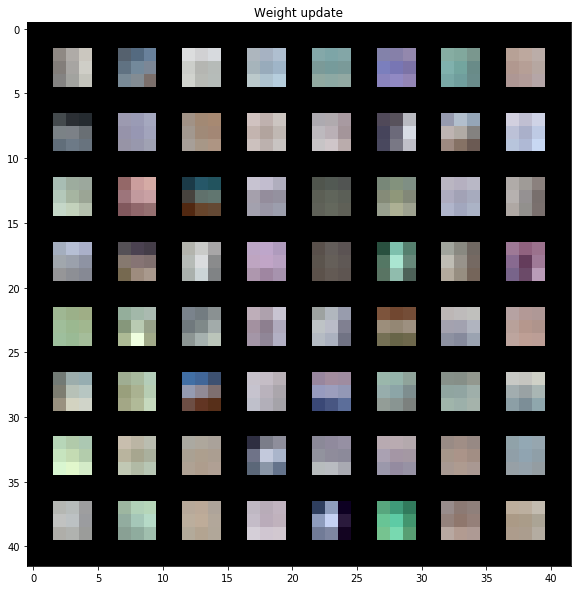

In [24]:
cll_weights = cll_weights.view(64,3,3,3)
cll_weights_ft = copy.deepcopy(net.conv[0].weight.data)
cll_weights_ft = cll_weights_ft.view(64,3,3,3)
 
if use_gpu: 
    cll_weights = cll_weights.cpu()
    cll_weights_ft = cll_weights_ft.cpu()
    
d_weights = cll_weights-cll_weights_ft

imshow(torchvision.utils.make_grid(cll_weights,nrow=8,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(cll_weights_ft,nrow=8,normalize=True),'Finetuned Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=8,normalize=True), 'Weight update')

## Performance of different Classes:


In [29]:
BatchSize

200

In [30]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [25]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        if use_gpu:        
            predicted = predicted.cpu()
        c = (predicted == labels).squeeze()
        for i in range(BatchSize):
            label = labels[i]
            class_correct[label] += float(c[i])
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (
        classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of plane : 82.600000 %
Accuracy of   car : 84.100000 %
Accuracy of  bird : 59.700000 %
Accuracy of   cat : 47.500000 %
Accuracy of  deer : 55.400000 %
Accuracy of   dog : 58.600000 %
Accuracy of  frog : 79.600000 %
Accuracy of horse : 73.600000 %
Accuracy of  ship : 75.500000 %
Accuracy of truck : 63.600000 %
